이번 주차 과제는 간단한 이미지 데이터를 활용해 크기가 큰 데이터의 차원 축소를 진행하고 데이터의 라벨에 따라 클러스터링을 진행하는 과제입니다.

###필요한 모듈을 가져오세요.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Image data 가져오기
https://www.kaggle.com/datasets/zalando-research/fashionmnist/data

###위 링크의 fashion mnist 데이터의 train dataset과 test dataset을 가져오세요.
(데이터의 용량이 크니 직접 다운로드 하지 말고 코드를 이용해 가져오도록 해보세요.)

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d zalando-research/fashionmnist

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
 76% 52.0M/68.8M [00:00<00:00, 134MB/s]
100% 68.8M/68.8M [00:00<00:00, 140MB/s]


In [4]:
!unzip fashionmnist.zip -d /content/fashionmnist

Archive:  fashionmnist.zip
  inflating: /content/fashionmnist/fashion-mnist_test.csv  
  inflating: /content/fashionmnist/fashion-mnist_train.csv  
  inflating: /content/fashionmnist/t10k-images-idx3-ubyte  
  inflating: /content/fashionmnist/t10k-labels-idx1-ubyte  
  inflating: /content/fashionmnist/train-images-idx3-ubyte  
  inflating: /content/fashionmnist/train-labels-idx1-ubyte  


In [5]:
train_data = pd.read_csv('/content/fashionmnist/fashion-mnist_train.csv')
test_data = pd.read_csv('/content/fashionmnist/fashion-mnist_test.csv')

train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###데이터에 대한 정보들을 보여주세요.
(필수: 요약, 모양, 크기, 결측치 여부 등)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [7]:
print(train_data.shape)
print(test_data.shape)

(60000, 785)
(10000, 785)


In [8]:
# 결측값이 있는 column print
print(train_data.columns[train_data.isna().any()])
print(test_data.columns[train_data.isna().any()])

Index([], dtype='object')
Index([], dtype='object')


### Data중 첫 번째 이미지를 보여주세요.

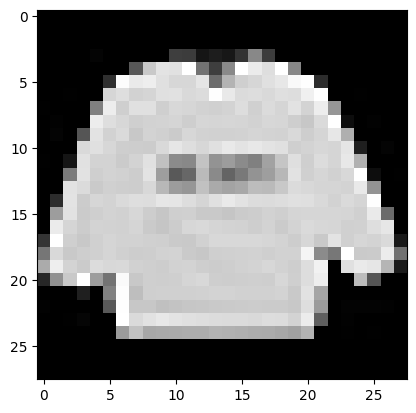

In [9]:
plt.imshow(train_data.iloc[0,1:].values.reshape(28,28), cmap='gray')
plt.show()

# 이미지 전처리

### 이미지 데이터를 머신러닝에 이용하기 편한 형태로 바꾸어 합니다.
(torch model 사용 - tensor 형태로 바꾸기 등)

In [10]:
import torch
X_train = train_data.drop(columns=['label']).values  # 특성 데이터를 numpy 배열로 변환
y_train = train_data['label'].values  # 레이블 데이터를 numpy 배열로 변환

# torch.Tensor를 사용하여 numpy 배열을 텐서로 변환
X_train = torch.Tensor(X_train)  # float형 텐서
y_train = torch.Tensor(y_train).long()  # 정수형 레이블 텐서로 변환

print(X_train.shape)
print(y_train.shape)

torch.Size([60000, 784])
torch.Size([60000])


In [11]:
X_test = test_data.drop(columns=['label']).values  # 특성 데이터를 numpy 배열로 변환
y_test = test_data['label'].values  # 레이블 데이터를 numpy 배열로 변환

# torch.Tensor를 사용하여 numpy 배열을 텐서로 변환
X_test = torch.Tensor(X_test)  # float형 텐서
y_test = torch.Tensor(y_test).long()  # 정수형 레이블 텐서로 변환

print(X_test.shape)
print(y_test.shape)

torch.Size([10000, 784])
torch.Size([10000])


### 이미지 데이터는 픽셀 값이 0 - 255로 이루어져 있습니다. 이 값을 0 - 1까지의 값으로 normalize 해주세요.

In [12]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### 추가적인 이미지 전처리를 진행해주세요.
(차원을 수정하는 것은 뒤의 문제에서 진행할 것이므로 여기에서 하지 마세요.)

In [13]:
# 표준화 진행
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 차원 축소
차원 축소란 고차원 데이터를 효율적으로 처리하기 위한 기법입니다.
### 그 중 대표적인 PCA와 t-sne에 대한 내용을 비교하여 아래에 적어주세요.

PCA(Principal Component Analysis)는 대표적인 차원 축소 기법 중 하나로 여러 차원들의 특징을 가장 잘 설명해 주는 차원인 주성분(Principal Component)을 이용하여 차원을 축소하는 방법  

**동작 과정**
1. 데이터 표준화 및 원점 이동  
  * 데이터의 값을 평균에서 빼서 표준편차로 나눠주는 표준화를 진행
2. 주성분 찾기  
  * 주성분은 데이터들의 중심(원점)을 지나면서 모든 데이터들에서의 수직 거리의 합이 가장 가깝도록 하는 선(임의의 선에 데이터를 투영했을 때 데이터들의 분산이 최대가 되는 선을 찾는 것)  
  * 두 번째 주성분은 첫 번째로 찾은 메인 주성분에 수직이면서 원점을 지나고, 데이터들과의 거리 합이 가장 작은 선  
3. 데이터 투영하기
  * 데이터들을 주성분 위로 옮기는 과정
4. 새로운 축 기준으로 데이터 회전하기
  * 새롭게 만들어진 변수인 첫 번째 주성분(PC1)과 두 번째 주성분(PC2)이 각각 x축과 y축이 될 수 있도록 축과 데이터 전체를 회전

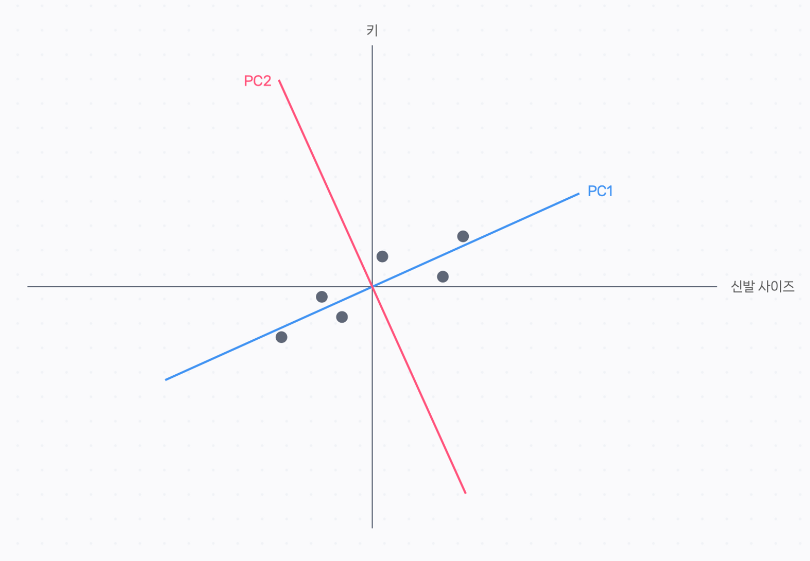

T-SNE(t-distributed stochastic neighbor embedding)는  고차원 공간에서의 점들의 유사성과 그에 해당하는 저차원 공간에서의 점들의 유사성을 계산하여, 이를 새로운 공간상에서 가까운 거리에 위치하도록 매핑하는 비선형 차원축소 방법  

**동작 과정**
x_i들은 기존의 고차원 공간에서의 점들이고, y_i는 t-SNE를 통하여 무작위로 저차원 공간으로 매핑된 점들.  
1. 모든 i,j 쌍에 대하여 x_i,x_j의 유사도를 정규분포를 이용하여 나타냄
2. 모든 i,j 쌍에 관하여 y_i, y_j의 유사도를 t분포를 이용하여 나타냄
3. 1., 2.의 각 유사도 분포가 같아지도록 y점들을 갱신
4. 수렴 할때까지 3.을 반복

낮은 차원 공간에서 t-분포를 이용하므로, 유사도가 큰 상태의 관계를 재현할 때는 낮은 차원 공간에서 데이터 포인트를 더 가까이 배치하고 유사도가 작은 상태의 관계를 재현할 때에는 낮은 차원 공간에서 데이터 포인트를 더 멀리 배치하도록 한다.

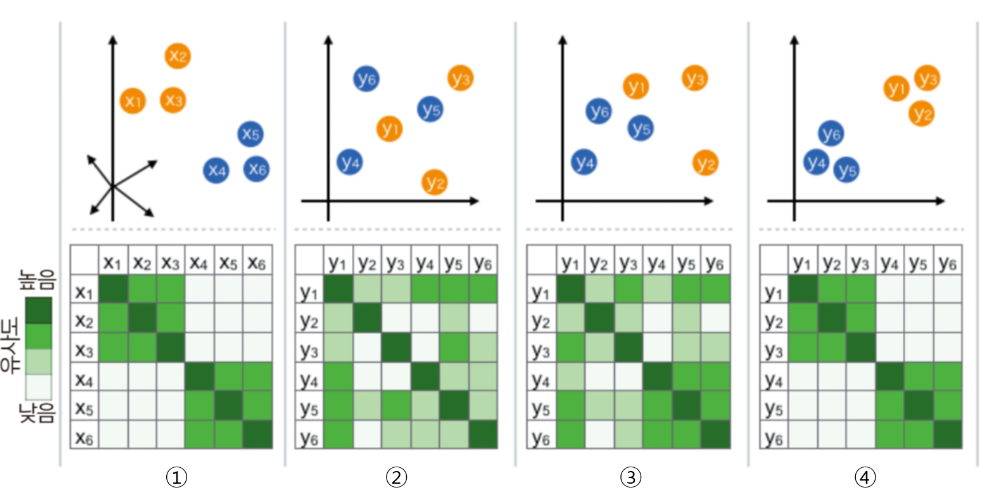

PCA와 t-SNE는 모두 비지도 학습 차원 축소 기법으로 고차원 데이터를 낮은 차원 공간에 시각화하기 위해 사용된다.  
* PCA는 데이터를 가장 큰 분산으로 변환하는 선형 차원 축소 기술이다. PCA는 비교적 단순하고 계산이 빠르다는 장점이 있지만 데이터 포인트 들 간 거리와 방향을 보존하지만, 비선형 구조를 보존하지는 못한다.
* t-SNE는 비선형 차원 축소 기술로, 고차원 데이터의 구조와 패턴을 보존하면서 낮은 차원으로 임베딩한다.t-SNE는 비선형 구조를 보존하고 데이터셋이 복잡할 경우 유용하다. 하지만 t-SNE 과정이 끝나면 input feature를 확인하기 어려우므로 시각화 툴로만 사용한다.

## PCA

### 현재 데이터는 28*28로 784차원을 가지고 있습니다. PCA를 이용하여 데이터들을 가장 잘 설명하는 50개의 변수만으로 데이터를 변환하시오.

In [14]:
pca = PCA(n_components=50)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
pca_df = pd.DataFrame(X_train_pca)
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,10.664973,14.993363,-0.689468,-10.980911,4.788254,0.559623,2.141115,-2.582798,4.525370,-0.758691,...,-0.200815,2.093832,-2.649151,0.584547,-3.198997,0.931557,0.671448,-3.322163,-3.234487,-2.072469
1,-11.989748,11.812770,-5.801049,-3.418630,-4.630651,2.061772,-3.109565,-3.308504,4.461980,5.669061,...,-0.824997,0.101802,0.369254,1.531920,-1.126123,0.741343,-0.009300,0.164383,-1.490346,-0.063202
2,20.517671,1.579784,6.770122,-2.884370,-5.379185,2.618096,-0.246181,-2.936941,-3.415353,-1.236735,...,-1.957848,-2.227821,-0.091630,0.003808,-0.578399,0.028129,-0.210052,2.076799,0.192753,0.918068
3,9.634535,-6.790917,-0.907860,4.577228,8.377438,-0.094375,-8.672806,-0.604500,2.566944,-3.070933,...,-1.485479,-1.724208,1.067164,0.814213,1.961275,-1.002900,0.728221,-0.672422,0.431773,-0.651367
4,11.493442,-11.655488,-7.208333,-4.772964,-0.594114,0.553685,0.388620,-0.384219,-2.063610,-4.824830,...,1.416178,0.125579,0.848507,0.215370,0.524067,0.452894,-2.085419,-0.829703,-0.851354,0.858542


### PCA 이후 데이터들의 설명된 분산 비율 (explained variance ratio)를 출력하세요.

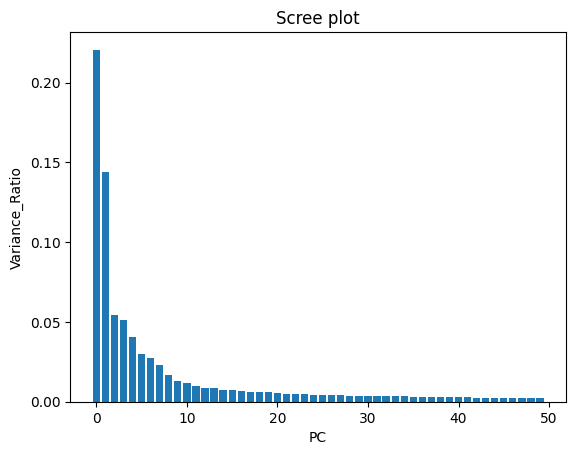

[0.22057176 0.14395563 0.05458802 0.05116399 0.04069273 0.03012154
 0.02750481 0.02325871 0.01694438 0.01309833 0.01161488 0.00963109
 0.00890642 0.00856623 0.00743049 0.00730157 0.00657498 0.00632692
 0.00623657 0.0058046  0.00515707 0.00511548 0.00472764 0.00453557
 0.00438423 0.00416784 0.00395056 0.00393244 0.00378355 0.00374478
 0.00368528 0.00353646 0.00336422 0.00330015 0.00329434 0.00319736
 0.00305999 0.00293714 0.00289203 0.00280918 0.00271998 0.00265986
 0.00255732 0.00253773 0.00245191 0.00243254 0.0023872  0.00228126
 0.00223339 0.00215709]


In [15]:
# PCA 개수
num_components = len(pca.explained_variance_ratio_)

x = np.arange(num_components)
var = pca.explained_variance_ratio_

plt.bar(x, var) # Bar plot 그리기

plt.xlabel('PC')  # 주성분
plt.ylabel('Variance_Ratio')  # 분산 비율
plt.title('Scree plot')

plt.show()

print(pca.explained_variance_ratio_)

In [16]:
# 누적 분산비율 구하기
cum_var = np.cumsum(var)
cum_vars = pd.DataFrame({'cum_vars': cum_var}, index = pca_df.columns)

cum_vars

,cum_vars
0,0.220572
1,0.364527
2,0.419115
3,0.470279
4,0.510972
5,0.541094
6,0.568598
7,0.591857
8,0.608802
9,0.621900


### PCA를 시행하면 데이터가 수정되므로 원본 데이터와 차이가 생기게 됩니다. 이때 이 차이를 재구성 오차(Reconstruction Error)라고 합니다. 재구성 오차를 mse(오차제곱합) 방식으로 구하시오.

In [17]:
from sklearn.metrics import mean_squared_error
X_recovered = pca.inverse_transform(X_train_pca)
mse_value = mean_squared_error(X_train, X_recovered)
print('재구성 오차: ', mse_value)

재구성 오차:  0.19971274412992404


### 이번에는 PCA를 통해 원본 데이터를 30차원으로 줄이고, explained variance ratio와 reconstructon error를 구하시오.

In [18]:
pca1 = PCA(n_components=30)
pca1.fit(X_train)
X_train_pca1 = pca1.transform(X_train)
pca_df1 = pd.DataFrame(X_train_pca1)

# 누적 분산비율 구하기
cum_var1 = np.cumsum(pca1.explained_variance_ratio_)
cum_vars1 = pd.DataFrame({'cum_vars': cum_var1}, index = pca_df1.columns)

X_recovered1 = pca1.inverse_transform(X_train_pca1)
mse_value1 = mean_squared_error(X_train, X_recovered1)

print('설명된 분산 비율: ', pca1.explained_variance_ratio_, '\n')
print('누적 분산비율: ', cum_vars1, '\n')
print('재구성 오차: ', mse_value1)

설명된 분산 비율:  [0.22057176 0.14395563 0.05458802 0.05116399 0.04069273 0.03012154
 0.02750481 0.02325871 0.01694438 0.01309833 0.01161488 0.00963109
 0.00890642 0.00856623 0.00743049 0.00730157 0.00657498 0.00632692
 0.00623657 0.0058046  0.00515707 0.00511548 0.00472764 0.00453557
 0.00438423 0.00416784 0.00395056 0.00393244 0.00378355 0.00374478] 

누적 분산비율:      cum_vars
0   0.220572
1   0.364527
2   0.419115
3   0.470279
4   0.510972
5   0.541094
6   0.568598
7   0.591857
8   0.608802
9   0.621900
10  0.633515
11  0.643146
12  0.652052
13  0.660619
14  0.668049
15  0.675351
16  0.681926
17  0.688252
18  0.694489
19  0.700294
20  0.705451
21  0.710566
22  0.715294
23  0.719829
24  0.724214
25  0.728381
26  0.732332
27  0.736264
28  0.740048
29  0.743793 

재구성 오차:  0.2562071756588093


### 데이터를 30차원으로 줄인 결과와 50차원으로 줄인 결과에는 어떤 차이가 있습니까?

50차원으로 줄였을 때는 80%정도의 설명력을 가졌는데 30차원으로 줄였을 때는 원본 데이터를 74%정도의 설명력을 가지므로 데이터를 재구성할 때 원본 데이터와의 차이가 차원이 줄어들면서 더 커진다.

### 마지막으로 원본 데이터를 2차원으로 줄이고, explained variance ratio와 reconstruction error를 구하시오.

In [19]:
pca2 = PCA(n_components=2)
pca2.fit(X_train)
X_train_pca2 = pca2.transform(X_train)
pca_df2 = pd.DataFrame(X_train_pca2)

# 누적 분산비율 구하기
cum_var2 = np.cumsum(pca2.explained_variance_ratio_)
cum_vars2 = pd.DataFrame({'cum_vars': cum_var2}, index = pca_df2.columns)

X_recovered2 = pca2.inverse_transform(X_train_pca2)
mse_value2 = mean_squared_error(X_train, X_recovered2)

print('설명된 분산 비율: ', pca2.explained_variance_ratio_, '\n')
print('누적 분산비율: ', cum_vars2, '\n')
print('재구성 오차: ', mse_value2)

설명된 분산 비율:  [0.22057176 0.14395563] 

누적 분산비율:     cum_vars
0  0.220572
1  0.364527 

재구성 오차:  0.6354726143474569


### 2차원으로 축소한 데이터를 시각화하여 보여주세요. 대신 데이터의 label에 따라 색상을 다르게 해주세요.

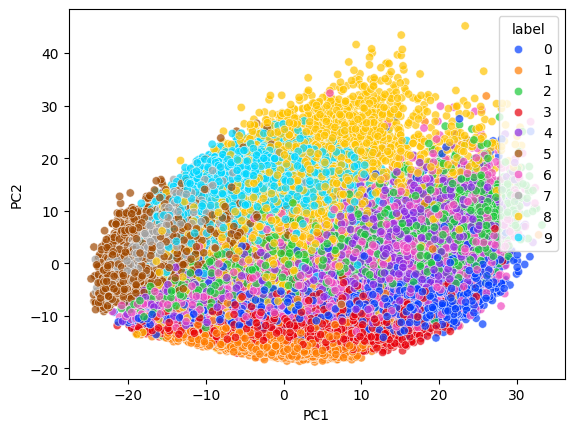

In [20]:
pca_df2.columns = ['PC1', 'PC2']
pca_df2['label'] = y_train
sns.scatterplot(data=pca_df2, x ='PC1', y='PC2', hue='label', alpha=0.7, palette='bright')
plt.show()

## T-SNE

### 앞서 pca를 통해 50차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

[13.617163 54.960102]


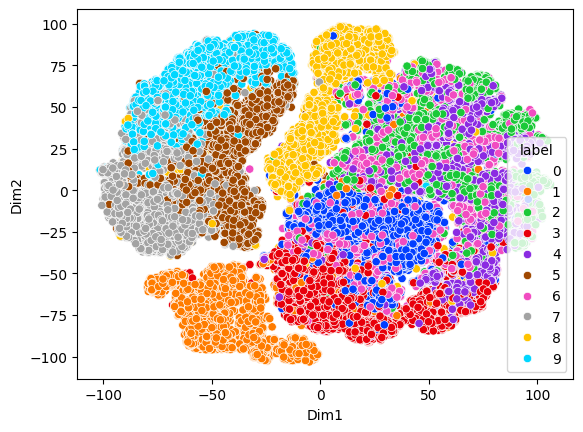

In [21]:
# 축소한 차원의 수를 정합니다.
n_components = 2
# TSNE 모델의 인스턴스를 만듭니다.
model = TSNE(n_components=n_components)
# data를 가지고 TSNE 모델을 훈련(적용) 합니다.
X_embedded = model.fit_transform(X_train_pca)
# 훈련된(차원 축소된) 데이터의 첫번째 값을 출력해 봅니다.
print(X_embedded[0])

# 차원 축소된 데이터를 그래프로 만들어서 화면에 출력해 봅니다.
palette = sns.color_palette("bright", 10)

# Create a DataFrame from the embedded data
embedded_df = pd.DataFrame(X_embedded, columns=['Dim1', 'Dim2'])
embedded_df['label'] = y_train # Add the labels to the DataFrame

# Use the DataFrame in sns.scatterplot
sns.scatterplot(data=embedded_df, x='Dim1', y='Dim2', hue='label', legend='full', palette=palette)
plt.show()

### 앞서 pca를 통해 30차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

[10.913863 59.246296]


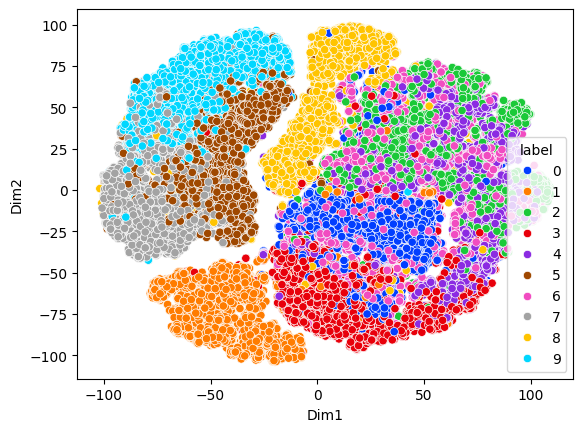

In [22]:
# 축소한 차원의 수를 정합니다.
n_components = 2
# TSNE 모델의 인스턴스를 만듭니다.
model1 = TSNE(n_components=n_components)
# data를 가지고 TSNE 모델을 훈련(적용) 합니다.
X_embedded1 = model1.fit_transform(X_train_pca1)
# 훈련된(차원 축소된) 데이터의 첫번째 값을 출력해 봅니다.
print(X_embedded1[0])

# 차원 축소된 데이터를 그래프로 만들어서 화면에 출력해 봅니다.
palette = sns.color_palette("bright", 10)

# Create a DataFrame from the embedded data
embedded_df1 = pd.DataFrame(X_embedded1, columns=['Dim1', 'Dim2'])
embedded_df1['label'] = y_train # Add the labels to the DataFrame

# Use the DataFrame in sns.scatterplot
sns.scatterplot(data=embedded_df1, x='Dim1', y='Dim2', hue='label', legend='full', palette=palette)
plt.show()

## 군집화

### PCA를 통해 50차원으로 줄인 데이터를 DBSCAN을 이용하여 군집화 하시오.

In [38]:
dbscan_model = DBSCAN(eps=20, min_samples=2)
dbscan_model.fit(X_train_pca)

pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(50)])
pca_df['DBSCAN_cluster'] = dbscan_model.labels_

# 클러스터 결과 확인
pca_df['DBSCAN_cluster'].value_counts()

,count
DBSCAN_cluster,
0,59454
-1,474
1,4
18,4
11,3
24,3
17,3
16,3
15,3


### k-means를 통해 50차원으로 줄인 데이터를 군집화 하시오.(군집의 개수는 10개로 하시오.)

In [39]:
kmeans_model = KMeans(n_clusters=10)
kmeans_model.fit(X_train_pca)

pca_df['kmeans_cluster'] = kmeans_model.labels_

pca_df['kmeans_cluster'].value_counts()

,count
kmeans_cluster,
3,9968
1,8286
2,7704
7,7536
8,6300
9,6141
0,4859
4,4029
5,2787


### 엘보우 메소드를 이용하여 k-means에서 가장 적절한 군집의 개수를 구하시오.

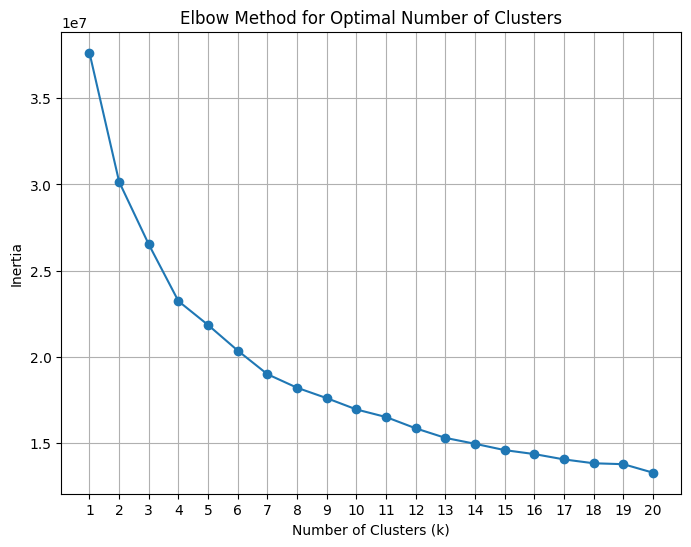

In [42]:
num_clusters = range(1, 21)
inertia = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(num_clusters, inertia, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.xticks(num_clusters)
plt.grid(True)
plt.show()

### k-means 최적의 군집 개수로 다시 군집화 하여 시각화 하시오.

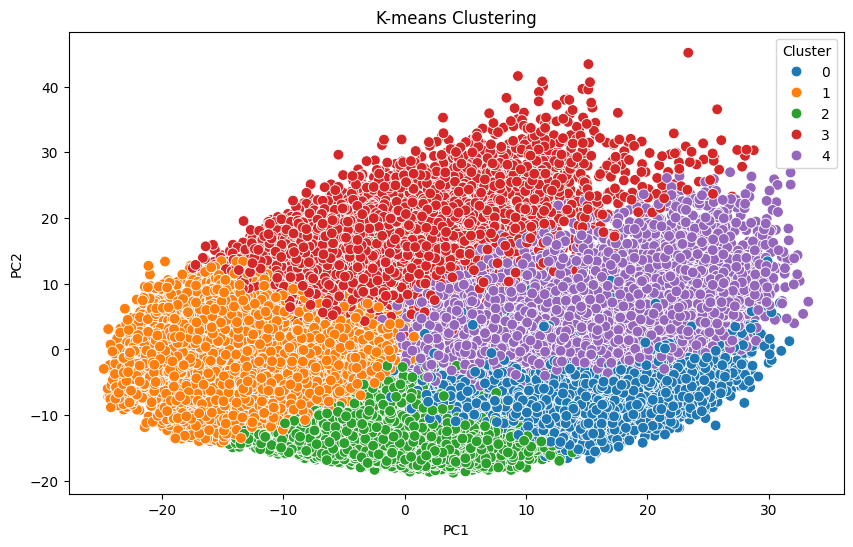

In [47]:
kmeans_model = KMeans(n_clusters=5)
kmeans_model.fit(X_train_pca)

pca_df['kmeans_cluster'] = kmeans_model.labels_

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='kmeans_cluster', palette='tab10', s=60)
plt.title("K-means Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.show()

### 다른 추가적인 군집화 기법을 2가지 이상 사용하여 pca 50 데이터를 시각화 하시오.

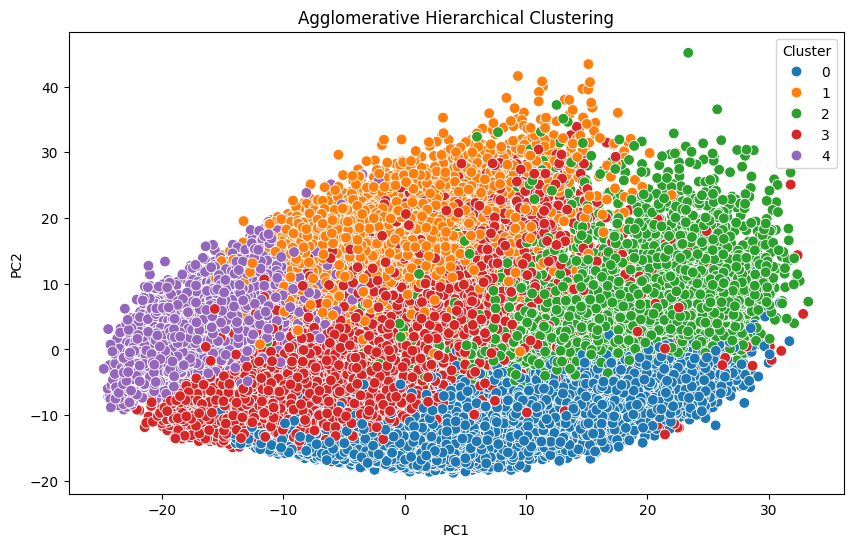

In [55]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative Clustering 모델 설정 및 학습
agglo_model = AgglomerativeClustering(n_clusters=5)  # n_clusters로 원하는 군집 개수 지정
agglo_cluster_labels = agglo_model.fit_predict(X_train_pca)

# 결과를 pca_df 데이터프레임에 저장
pca_df['Agglo_cluster'] = agglo_cluster_labels

# 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Agglo_cluster', palette='tab10', s=60)
plt.title("Agglomerative Hierarchical Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.show()


In [58]:
pca_df['Agglo_cluster'].value_counts()

,count
Agglo_cluster,
0,17172
3,13261
4,13060
2,9772
1,6735


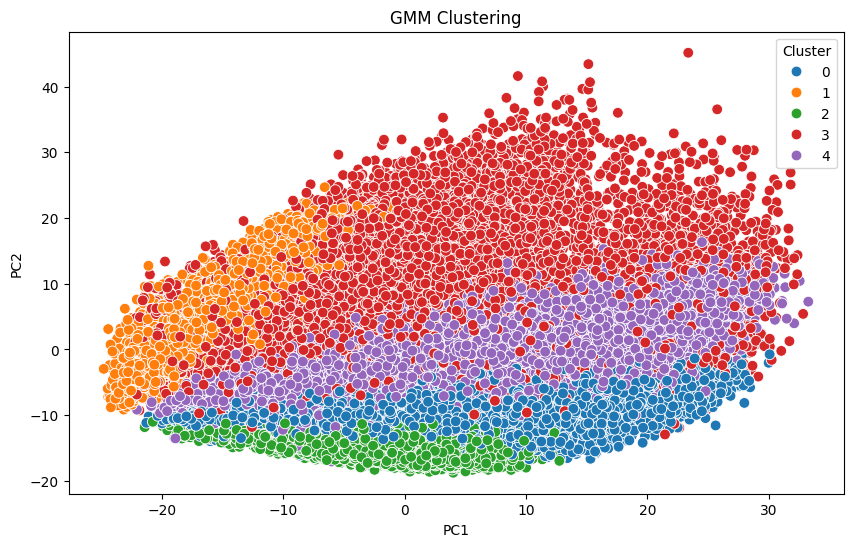

In [50]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5)
gmm.fit(X_train_pca)
gmm_cluster_labels = gmm.predict(X_train_pca)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=gmm_cluster_labels, palette='tab10', s=60)
plt.title("GMM Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.show()

In [59]:
cluster_counts = pd.Series(gmm_cluster_labels).value_counts()
cluster_counts

,count
4,15457
3,13808
1,12467
0,10628
2,7640


## 군집화 결과 비교

### 앞선 모든 군집화 모델의 결과를 실루엣 점수(Silhouette score)를 이용하여 성능을 비교하시오.

**실루엣 점수**는 개별 데이터가 할당된 군집 내 데이터와 얼마나 가깝게 군집화 되어있는지, 그리고 다른 군집에 있는 데이터와는 얼마나 멀리 분리되어 있는지를 수치로 나타낸 것. 1에 가까울 수록 근처 군집과 멀리 떨어져 있고, 0에 가까울수록 근처 군집과 가깝다는 것을 의미한다.

In [60]:
# DBSCAN 군집 결과에서 노이즈가 아닌 포인트만 선택
mask = dbscan_model.labels_ != -1
X_filtered = X_train_pca[mask]
labels_filtered = dbscan_model.labels_[mask]

# 실루엣 점수 계산
if len(set(labels_filtered)) > 1:
    score = silhouette_score(X_filtered, labels_filtered)
    print(f'Silhouette Score: {score:.2f}')
else:
    print("Silhouette Score could not be calculated due to a lack of multiple clusters.")

Silhouette Score: 0.20


In [65]:
# K-means 클러스터의 실루엣 점수 계산
score = silhouette_score(X_train_pca, kmeans_model.labels_)
print(f'Silhouette Score: {score:.2f}')

Silhouette Score: 0.18


In [62]:
score = silhouette_score(X_train_pca, agglo_cluster_labels)
print(f'Silhouette Score: {score:.2f}')

Silhouette Score: 0.16


In [63]:
score = silhouette_score(X_train_pca, gmm_cluster_labels)
print(f'Silhouette Score: {score:.2f}')

Silhouette Score: 0.12


### 실루엣 점수를 통해 군집화 모델의 성능에 대한 간단한 해석을 적으세요.

군집화 모델의 성능이 DBSCAN, K-means, Agglomerative, GMM순으로 높게 나타나고 DBSCAN의 실루엣 점수가 0.2로 클러스터 간의 분리가 불분명하다고 해석할 수 있다. 모델들의 파라미터를 조정하거나 차원의 수를 조정하여 최적의 군집을 찾아보는 것을 시도해보는 게 좋을 듯.